In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_models(server_datasets: list[pd.DataFrame]):

    best_neighbors = []
    best_f1_scores = []
    model_instance_list = []
    dataset_sizes = []
        
    
    for i, df in enumerate(server_datasets):
        params = {"n_neighbors": np.arange(3, 101, 2)}
        knn = KNeighborsClassifier()
        model = GridSearchCV(knn, params, scoring='f1_macro', cv=3, n_jobs=-1)
        
        X_server = df.drop(['target'], axis=1)
        y_server = df['target']
        
        # Split server data for validation
        X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
            X_server, y_server, test_size=0.3, random_state=42, stratify=y_server
        )
        
        model.fit(X_s_train, y_s_train)
        y_pred = model.predict(X_s_test)
        
        best_neighbors.append(model.best_params_['n_neighbors'])
        best_f1_scores.append(f1_score(y_s_test, y_pred))
        model_instance_list.append(model)
        
        # # Compute median distances (possible logical flaw)
        # nbrs = model.best_estimator_
        # distances, indices = nbrs.kneighbors(X_s_train)
        # distances_no_self = distances[:, 1:]
        # median_neighbor_distance.append(np.median(distances_no_self))
        
        dataset_sizes.append(df.shape[0])

    return (best_neighbors, best_f1_scores, model_instance_list, dataset_sizes)

In [3]:
class ModelPerformanceAnalyzer:
    def __init__(self, models: list[GridSearchCV], model_names = None):
        self.models = models
        self.model_names = model_names or [f"Model_{i}" for i in range(len(models))]
        self.performance_df = None
    
    def analyze_models(self, X_unseen, y_unseen, include_additional_metrics = True):
        results = []
        for i, (model, name) in enumerate(zip(self.models, self.model_names)):
            print(f"Analyzing {name}...")
            
            model_metrics = self._analyze_single_model(
                model, name, i, X_unseen, y_unseen
            )
            results.append(model_metrics)
        
        self.performance_df = pd.DataFrame(results)
        return self.performance_df
    
    
    def _analyze_single_model(self, model, name, index, X_unseen, y_unseen):

        #Predictions and probabilities
        y_pred = model.predict(X_unseen)
        y_proba = model.predict_proba(X_unseen)

        #Distance metrics

        metrics = {
            'model_name': name,
            'model_index': index,
            'f1_score': f1_score(y_unseen, y_pred, average='weighted'),
            'classification_probabilities': y_proba.tolist()
        }

        distance_metrics = self._calculate_distance_metrics(model, X_unseen)
        metrics.update(distance_metrics)
        return metrics


    def _calculate_distance_metrics(self, model: GridSearchCV, X_unseen):
        """Calculate various distance-based metrics."""
        try:
            nbrs = model.best_estimator_
            
            # Calculate distance matrix
            distances, indices = nbrs.kneighbors(X_unseen)
            distances_no_self = distances[:, 1:]
            
            # Various distance statistics
            point_medians = np.median(distances_no_self, axis=1)
            point_means = np.mean(distances_no_self, axis=1)
            point_mins = np.min(distances_no_self, axis=1)
            point_maxs = np.max(distances_no_self, axis=1)
            
            return {
                'median_distance_all_points': np.median(point_medians),
                'mean_distance_all_points': np.mean(point_means),
                'min_distance_all_points': np.min(point_mins),
                'max_distance_all_points': np.max(point_maxs),
                'distance_std': np.std(distances_no_self),
            }
        except Exception as e:
            warnings.warn(f"Distance calculation failed for model: {e}")
            return {
                'median_distance_all_points': np.nan,
                'mean_distance_all_points': np.nan,
                'min_distance_all_points': np.nan,
                'max_distance_all_points': np.nan,
                'distance_std': np.nan,
            }
    def get_probability_matrix(self, model_index):
        """Get probability matrix for a specific model as numpy array."""
        if self.performance_df is not None:
            return np.array(self.performance_df.loc[model_index, 'classification_probabilities'])
        return None
    
    def get_all_probabilities(self):
        """Get all probability matrices as a 3D array (models x samples x classes)."""
        if self.performance_df is not None:
            return np.array([np.array(probs) for probs in self.performance_df['classification_probabilities']])
        return None

In [4]:
def run_distributed_knn_simulation(data, n_simulations=10, n_servers=100, test_size=0.2):
    """
    Optimized version using ModelPerformanceAnalyzer for probability extraction
    """
    simulation_results = []

    all_medians = []
    all_means = []
    
    for sim in range(n_simulations):
        print(f"Running simulation {sim+1}/{n_simulations}")
        
        # 1. Split data
        X = data.drop(['target'], axis=1)
        y = data['target']
        
        X_train_full, X_test_heldout, y_train_full, y_test_heldout = train_test_split(
            X, y, test_size=test_size, random_state=sim, stratify=y
        )
        
        # 2. Generate server datasets
        def generate_server_datasets(data, n_servers=100):
            server_datasets = []
            min_samples = 500
            max_samples = 2000
            
            for _ in range(n_servers):
                sample_size = np.random.randint(min_samples, max_samples)
                start_idx = np.random.randint(0, len(data) - sample_size)
                server_data = data.iloc[start_idx:start_idx + sample_size]
                server_datasets.append(server_data)
            
            return server_datasets
        
        server_datasets = generate_server_datasets(
            pd.concat([X_train_full, y_train_full], axis=1),
            n_servers=n_servers
        )
        
        # 3. Train models
        best_neighbors, best_f1_scores, model_instance_list, dataset_sizes = create_models(server_datasets)
        
        metrics_df = pd.DataFrame({
            'optimal_k_value': best_neighbors,
            'best_f1_scores': best_f1_scores,
            'model_instance': model_instance_list,
            'dataset_size': dataset_sizes
        })

        metrics_df = metrics_df[metrics_df['best_f1_scores'] != 0]
        
        # 4. Test on held-out data
        n_test_samples = min(500, len(X_test_heldout))
        test_indices = np.random.choice(len(X_test_heldout), size=n_test_samples, replace=False)
        X_test_samples = X_test_heldout.iloc[test_indices]
        y_test_true = y_test_heldout.iloc[test_indices]

        # Use ModelPerformanceAnalyzer to get all metrics and probabilities
        analyzer = ModelPerformanceAnalyzer(metrics_df['model_instance'].tolist())
        analysis_df = analyzer.analyze_models(X_test_samples, y_test_true)
        
        # Merge results
        metrics_df = metrics_df.merge(
            analysis_df[['model_index', 'median_distance_all_points', 'mean_distance_all_points']], 
            left_index=True, 
            right_on='model_index'
        )
        
        all_medians.extend(metrics_df['median_distance_all_points'].tolist())
        all_means.extend(metrics_df['mean_distance_all_points'].tolist())
        
        # Define scoring functions
        def arctan_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 0.5 + (np.arctan(((max_d + min_d)/2) - distance)/np.pi)
        
        def tanh_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 0.5 + 0.5*(np.tanh(((max_d + min_d)/2) - distance))
        
        def sigmoid_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 1 / (1 + 2*np.exp(((max_d + min_d)/2) - distance))
        
        # Calculate scores
        metrics_df['arctan_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: arctan_score(x, metrics_df)
        )
        metrics_df['tanh_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: tanh_score(x, metrics_df)
        )
        metrics_df['sigmoid_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: sigmoid_score(x, metrics_df)
        )
        
        # Extract probabilities from analyzer (more efficient)
        probability_list = []
        for i in range(len(X_test_samples)):
            point_probs = []
            for model_idx in range(len(metrics_df)):
                model_probs = analyzer.get_probability_matrix(model_idx)
                point_probs.append(model_probs[i])
            probability_list.append(point_probs)
        
        probability_list = np.array(probability_list)
        
        # Calculate weighted predictions
        approaches = {
            'approach_1': 'arctan_score',
            'approach_2': 'dataset_size', 
            'approach_3': 'tanh_score',
            'approach_4': 'sigmoid_score'
        }
        
        approach_preds = {}
        for approach_name, weight_col in approaches.items():
            if weight_col == 'dataset_size':
                weights = metrics_df[weight_col].values
            else:
                weights = metrics_df[weight_col].values
            
            weighted_results = []
            for probability in probability_list:
                weighted = probability * weights.reshape(-1, 1)
                weighted_results.append(weighted.sum(axis=0) / weights.sum())
            
            approach_preds[approach_name] = np.array([np.argmax(p) for p in weighted_results])
        
        # Calculate metrics
        sim_result = {'simulation': sim}
        for approach_name, preds in approach_preds.items():
            sim_result[f'{approach_name}_f1'] = f1_score(y_test_true, preds, average='weighted')
            sim_result[f'{approach_name}_acc'] = accuracy_score(y_test_true, preds)
        
        sim_result.update({
            'n_servers': len(metrics_df),
            'avg_dataset_size': metrics_df['dataset_size'].mean(),
            'avg_median_distance': metrics_df['median_distance_all_points'].mean()
        })
        
        simulation_results.append(sim_result)
    
    return pd.DataFrame(simulation_results), all_medians, all_means

In [5]:
# %%
# Load your data
data = pd.read_csv('./data/std-normal.csv')

# Run multiple simulations
results_df, all_medians, all_means = run_distributed_knn_simulation(data, n_simulations=20, n_servers=100)

Running simulation 1/20
Analyzing Model_0...
Analyzing Model_1...
Analyzing Model_2...
Analyzing Model_3...
Analyzing Model_4...
Analyzing Model_5...
Analyzing Model_6...
Analyzing Model_7...
Analyzing Model_8...
Analyzing Model_9...
Analyzing Model_10...
Analyzing Model_11...
Analyzing Model_12...
Analyzing Model_13...
Analyzing Model_14...
Analyzing Model_15...
Analyzing Model_16...
Analyzing Model_17...
Analyzing Model_18...
Analyzing Model_19...
Analyzing Model_20...
Analyzing Model_21...
Analyzing Model_22...
Analyzing Model_23...
Analyzing Model_24...
Analyzing Model_25...
Analyzing Model_26...
Analyzing Model_27...
Analyzing Model_28...
Analyzing Model_29...
Analyzing Model_30...
Analyzing Model_31...
Analyzing Model_32...
Analyzing Model_33...
Analyzing Model_34...
Analyzing Model_35...
Analyzing Model_36...
Analyzing Model_37...
Analyzing Model_38...
Analyzing Model_39...
Analyzing Model_40...
Analyzing Model_41...
Analyzing Model_42...
Analyzing Model_43...
Analyzing Model_44

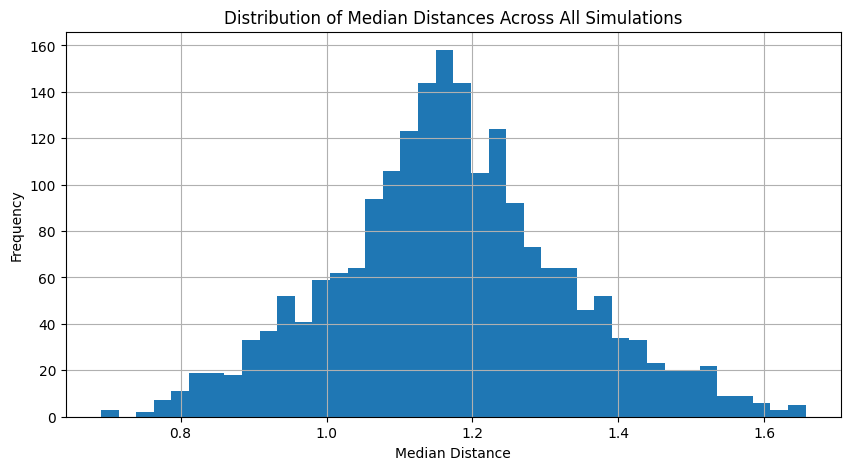

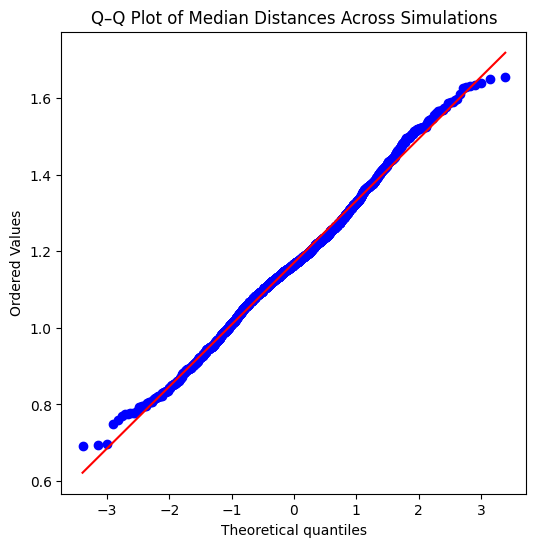

In [6]:
import scipy.stats as stats

plt.figure(figsize=(10, 5))
plt.hist(all_medians, bins=40)
plt.title('Distribution of Median Distances Across All Simulations')
plt.xlabel('Median Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(all_medians, dist="norm", plot=plt)
plt.title('Q–Q Plot of Median Distances Across Simulations')
plt.show()

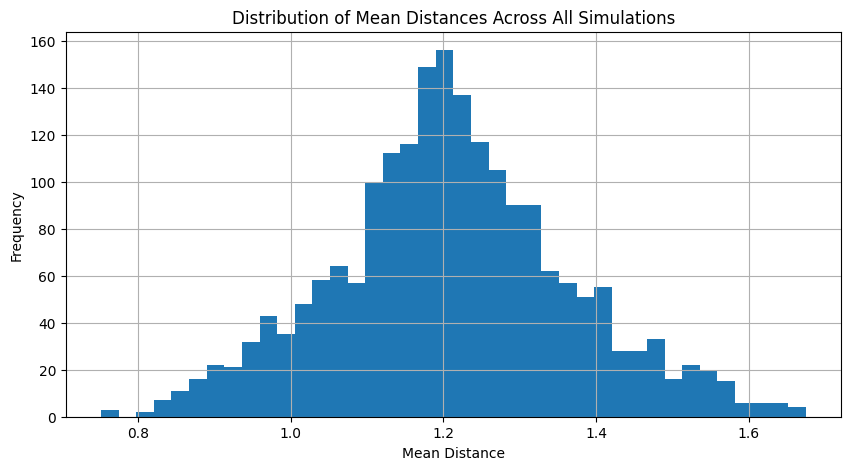

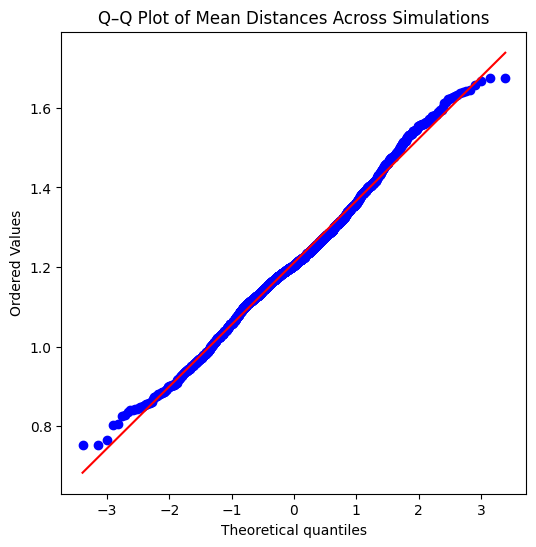

In [7]:
import scipy.stats as stats

plt.figure(figsize=(10, 5))
plt.hist(all_means, bins=40)
plt.title('Distribution of Mean Distances Across All Simulations')
plt.xlabel('Mean Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(all_means, dist="norm", plot=plt)
plt.title('Q–Q Plot of Mean Distances Across Simulations')
plt.show()

In [8]:
# Find the best KNN on overall data
from sklearn.ensemble import BaggingClassifier
X = data.drop(['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
params = {"n_neighbors": np.arange(3, 101, 2)}
knn = KNeighborsClassifier()
temp_model = GridSearchCV(knn, params, scoring='f1_macro', cv=3, n_jobs=-1)
model = BaggingClassifier(estimator=temp_model, n_estimators=100, n_jobs=-1, random_state=42, max_samples=0.7)
model.fit(X_train, y_train)
temp_model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Best K: {temp_model.best_params_['n_neighbors']}")
print(f"Best F1 Score: {f1_score(y_test, y_pred)}")

benchmark_f1 = f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1350
           1       0.98      0.98      0.98      1350

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700

Best K: 97
Best F1 Score: 0.9829881656804734


In [9]:
# %%
# Analyze results
print("Simulation Results Summary:")
print("=" * 50)
print(f"Number of simulations: {len(results_df)}")
print(f"Average F1 Scores:")
print(f"Approach 1 (Arctan): {results_df['approach_1_f1'].mean():.4f} ± {results_df['approach_1_f1'].std():.4f}")
print(f"Approach 2 (Size):   {results_df['approach_2_f1'].mean():.4f} ± {results_df['approach_2_f1'].std():.4f}")
print(f"Approach 3 (Tanh):   {results_df['approach_3_f1'].mean():.4f} ± {results_df['approach_3_f1'].std():.4f}")
print(f"Approach 4 (Sigmoid):   {results_df['approach_4_f1'].mean():.4f} ± {results_df['approach_4_f1'].std():.4f}")


Simulation Results Summary:
Number of simulations: 20
Average F1 Scores:
Approach 1 (Arctan): 0.9887 ± 0.0050
Approach 2 (Size):   0.9890 ± 0.0049
Approach 3 (Tanh):   0.9884 ± 0.0050
Approach 4 (Sigmoid):   0.9894 ± 0.0047


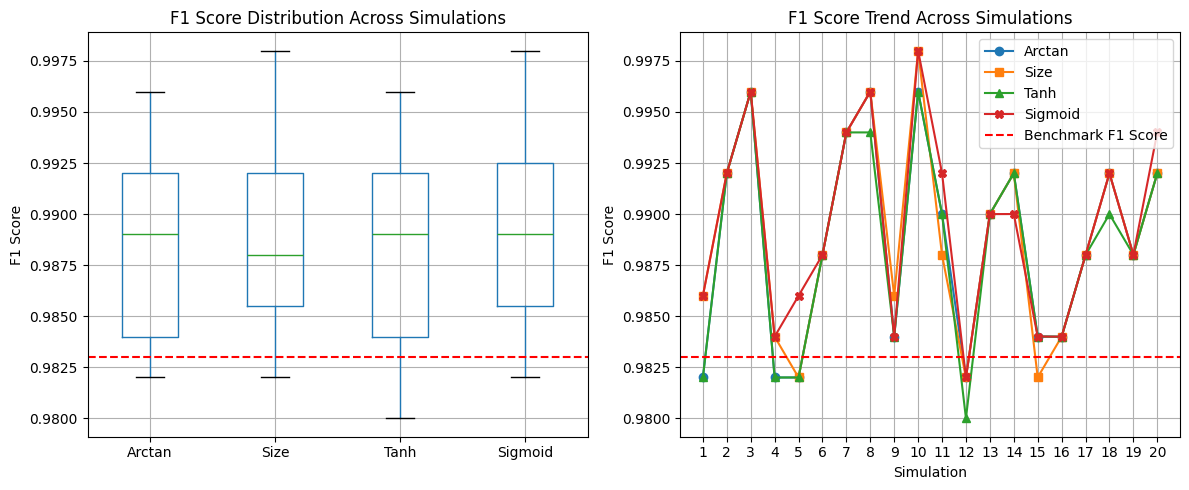

In [10]:
# %%
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
results_df[['approach_1_f1', 'approach_2_f1', 'approach_3_f1', 'approach_4_f1']].boxplot()
plt.title('F1 Score Distribution Across Simulations')
plt.ylabel('F1 Score')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks([1, 2, 3, 4], ['Arctan', 'Size', 'Tanh', 'Sigmoid'])

plt.subplot(1, 2, 2)
plt.plot(results_df['approach_1_f1'], label='Arctan', marker='o')
plt.plot(results_df['approach_2_f1'], label='Size', marker='s')
plt.plot(results_df['approach_3_f1'], label='Tanh', marker='^')
plt.plot(results_df['approach_4_f1'], label='Sigmoid', marker='X')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks(np.arange(len(results_df)), np.arange(1, len(results_df)+1))
plt.xlabel('Simulation')
plt.ylabel('F1 Score')
plt.title('F1 Score Trend Across Simulations')
plt.legend()
plt.grid(True)

plt.savefig('./plots/f1_score_trends_churndata.png')

plt.tight_layout()
plt.show()


In [11]:
# %%
# Statistical significance testing
from scipy.stats import ttest_rel

# Pairwise t-tests
t_stat_1_2, p_val_1_2 = ttest_rel(results_df['approach_1_f1'], results_df['approach_2_f1'])
t_stat_1_3, p_val_1_3 = ttest_rel(results_df['approach_1_f1'], results_df['approach_3_f1'])
t_stat_2_3, p_val_2_3 = ttest_rel(results_df['approach_2_f1'], results_df['approach_3_f1'])
t_stat_2_4, p_val_2_4 = ttest_rel(results_df['approach_2_f1'], results_df['approach_4_f1'])
t_stat_3_4, p_val_3_4 = ttest_rel(results_df['approach_3_f1'], results_df['approach_4_f1'])
t_stat_1_4, p_val_1_4 = ttest_rel(results_df['approach_1_f1'], results_df['approach_4_f1'])

print("\nStatistical Significance (paired t-tests):")
print(f"Arctan vs Size: p-value = {p_val_1_2:.4f}")
print(f"Arctan vs Tanh: p-value = {p_val_1_3:.4f}")
print(f"Size vs Tanh: p-value = {p_val_2_3:.4f}")
print(f"Size vs Sigmoid: p-value = {p_val_2_4:.4f}")
print(f"Tanh vs Sigmoid: p-value = {p_val_3_4:.4f}")
print(f"Arctan vs Sigmoid: p-value = {p_val_1_4:.4f}")


Statistical Significance (paired t-tests):
Arctan vs Size: p-value = 0.3302
Arctan vs Tanh: p-value = 0.0828
Size vs Tanh: p-value = 0.0829
Size vs Sigmoid: p-value = 0.2580
Tanh vs Sigmoid: p-value = 0.0084
Arctan vs Sigmoid: p-value = 0.0492
